2.1 Gắn nhãn ảnh 

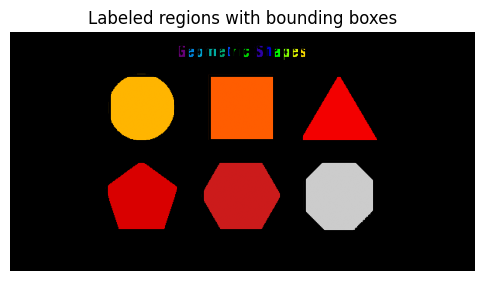

In [1]:
from PIL import Image
import numpy as np
import imageio.v2 as imageio
from scipy import ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)
thres = threshold_otsu(a)
b = a > thres
c = label(b)
label_image = Image.fromarray((c * 20).astype(np.uint8))  
imageio.imsave('label_output.jpg', label_image)
properties = regionprops(c)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(c, cmap='nipy_spectral')
for prop in properties:
    minr, minc, maxr, maxc = prop.bbox
    rect_width = maxc - minc
    rect_height = maxr - minr
    rect = mpatches.Rectangle((minc, minr), rect_width, rect_height,
                              fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
plt.title('Labeled regions with bounding boxes')
plt.axis('off')
plt.show()


2.2.Dò tìm cạnh theo chiều dọc

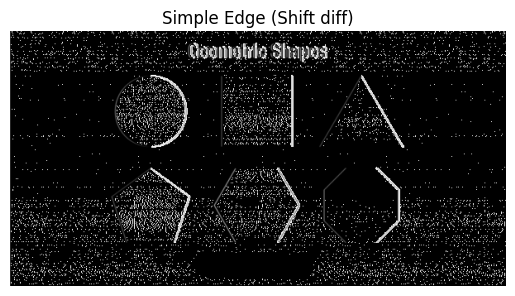

In [2]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)
bmg = np.abs(a - nd.shift(a, (0, 1), order=0))
plt.imshow(bmg, cmap='gray')
plt.title('Simple Edge (Shift diff)')
plt.axis('off')
plt.show()


2.3.Dò tìm cạnh với Sobel Filter

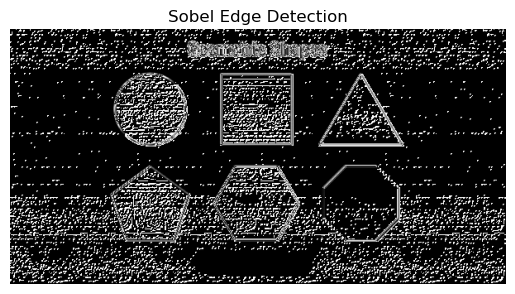

In [1]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu
data = Image.open('geometric.png').convert('L')
img = np.asarray(data)
a = nd.sobel(img, axis=0)
b = nd.sobel(img, axis=1)
bmg = np.abs(a) + np.abs(b)
plt.imshow(bmg, cmap='gray')
plt.title('Sobel Edge Detection')
plt.axis('off')
plt.show()


2.4.Xác định góc của đối tượng

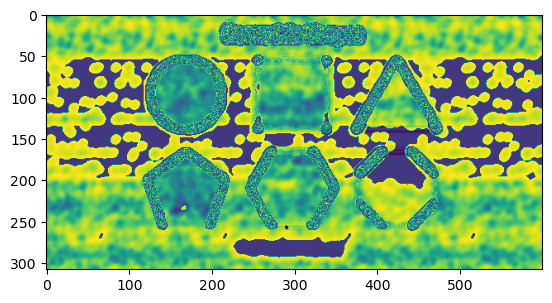

In [2]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def Harris(indata, alpha=0.2):
    x = nd.sobel(indata, 0)
    y = nd.sobel(indata, 1)
    x1 = x ** 2
    y1 = y ** 2
    xy = abs(x * y)
    x1 = nd.gaussian_filter(x1, 3)
    y1 = nd.gaussian_filter(y1, 3)
    xy = nd.gaussian_filter(xy, 3)
    detC = x1 * y1 - 2 * xy
    trC = x1 + y1
    R = detC - alpha * trC**2
    return R
data = Image.open('geometric.png').convert('L')
data = np.asarray(data)

bmg = Harris(data)
plt.imshow(bmg)
plt.show()


2.5.1.Dò tìm đường thẳng trong ảnh

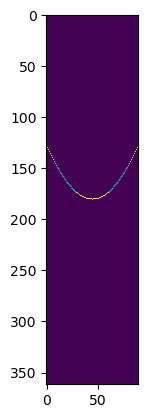

In [ ]:
2

2.5.2.Dò tìm đường tròn trong ảnh

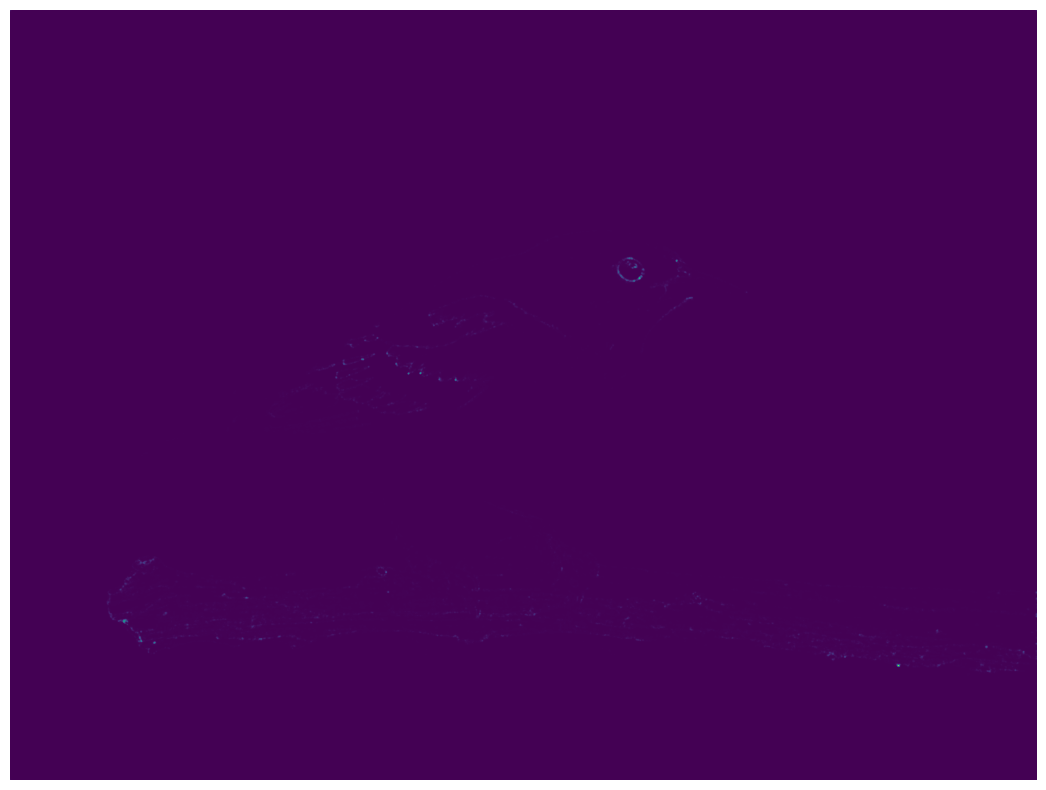

In [4]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray

data = iio.imread('bird.png')
image_gray = rgb2gray(data)
coordinate = corner_harris(image_gray, k=0.001)

plt.figure(figsize=(20, 10))
plt.imshow(coordinate)
plt.axis('off')
plt.show()


2.6.Image matching
Tìm điểm tương đồng giữa 2 ảnh
-Tìm điểm cần so sánh (Harris Corner Detector)
-Xem xét vùng chọn hình chữ nhật xung quanh những điểm cần so sánh
-Tính mô tả đặc trưng cục bộ cho mỗi điểm của mỗi ảnh
-Kiểm tra độ tương đồng giữa hai ảnh

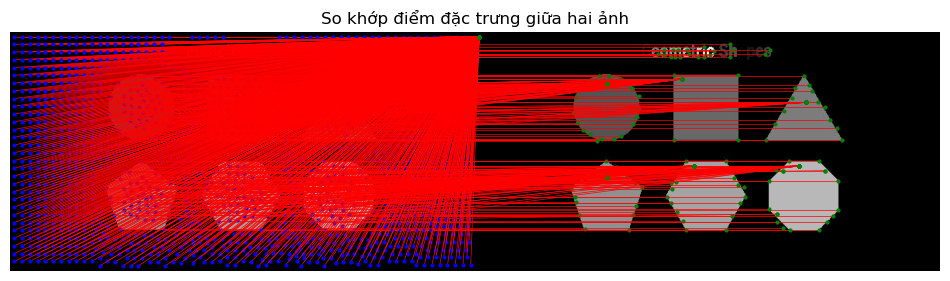

In [9]:
import numpy as np
import imageio.v2 as iio
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_peaks
from scipy.spatial.distance import cdist

def ensure_grayscale(img):
    if img.ndim == 3:
        return rgb2gray(img)
    return img

def detect_corners(image, min_dist=5):
    corners = corner_harris(image)
    coords = corner_peaks(corners, min_distance=min_dist)
    return coords

def extract_patch(img, coord, size=11):
    half = size // 2
    y, x = coord
    if y - half < 0 or x - half < 0 or y + half >= img.shape[0] or x + half >= img.shape[1]:
        return None
    return img[y - half:y + half + 1, x - half:x + half + 1]

def compute_descriptors(img, keypoints, size=11):
    descriptors = []
    valid_pts = []
    for pt in keypoints:
        patch = extract_patch(img, pt, size)
        if patch is not None:
            descriptors.append(patch.flatten())
            valid_pts.append(pt)
    return np.array(descriptors), valid_pts

def match_descriptors(desc1, desc2):
    D = cdist(desc1, desc2)
    matches = np.argmin(D, axis=1)
    return matches

def draw_matches(img1, img2, pts1, pts2, matches):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    canvas = np.zeros((max(h1, h2), w1 + w2))
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(canvas, cmap='gray')

    for i in range(len(pts1)):
        y1, x1 = pts1[i]
        y2, x2 = pts2[matches[i]]
        ax.plot([x1, x2 + w1], [y1, y2], 'r-', linewidth=0.5)
        ax.plot(x1, y1, 'bo', markersize=2)
        ax.plot(x2 + w1, y2, 'go', markersize=2)

    ax.axis('off')
    plt.title('So khớp điểm đặc trưng giữa hai ảnh')
    plt.show()

img1 = ensure_grayscale(iio.imread('label_output.jpg'))
img2 = ensure_grayscale(iio.imread('label_output.jpg'))

kp1 = detect_corners(img1)
kp2 = detect_corners(img2)

desc1, valid_pts1 = compute_descriptors(img1, kp1)
desc2, valid_pts2 = compute_descriptors(img2, kp2)

match_idx = match_descriptors(desc1, desc2)

draw_matches(img1, img2, valid_pts1, valid_pts2, match_idx)
